In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier


In [15]:
trades = pd.read_csv("data/historical_data.csv")
sentiment = pd.read_csv("data/fear_greed_index.csv")


In [16]:
def clean_cols(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

trades = clean_cols(trades)
sentiment = clean_cols(sentiment)


In [17]:
sentiment["date"] = pd.to_datetime(sentiment["date"], errors="coerce")
sentiment = sentiment.rename(columns={"classification": "sentiment"})
sentiment = sentiment[["date", "sentiment", "value"]]
sentiment = sentiment.dropna(subset=["date"])
sentiment = sentiment.sort_values("date")


In [18]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], unit="ms", errors="coerce")
trades["date"] = pd.to_datetime(trades["timestamp"].dt.date)

In [19]:
for col in ["closed_pnl", "execution_price", "size_tokens"]:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors="coerce")

In [20]:
df = trades.merge(
    sentiment,
    on="date",
    how="left"
)

df = df.sort_values("date")


In [21]:
df["value"] = df["value"].ffill()
df["sentiment"] = df["sentiment"].ffill()

In [22]:
df["value"] = df["value"].fillna(df["value"].median())
df["sentiment"] = df["sentiment"].fillna("Neutral")

In [23]:
df["profit"] = (df["closed_pnl"] > 0).astype(int)


In [24]:
df["side_encoded"] = np.nan

if "trade_side" in df.columns:
    df["side_encoded"] = df["trade_side"].map({"BUY": 1, "SELL": 0})

if "direction" in df.columns:
    df.loc[df["side_encoded"].isna(), "side_encoded"] = (
        df["direction"].map({"LONG": 1, "SHORT": 0})
    )

In [25]:
df["side_encoded"] = df["side_encoded"].fillna(0)

In [26]:
features = [
    "value",
    "side_encoded",
    "size_tokens",
    "execution_price"
]

df_model = df.copy()

df_model = df_model.dropna(subset=[
    "closed_pnl",
    "size_tokens",
    "execution_price"
])

print("Rows before modeling:", len(df_model))
print("Class distribution:\n", df_model["profit"].value_counts())


Rows before modeling: 211224
Class distribution:
 profit
0    124355
1     86869
Name: count, dtype: int64


In [27]:
X = df_model[features]
y = df_model["profit"]

split = int(len(df_model) * 0.75)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [28]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=50, n_estimators=400, random_state=42)

In [29]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.5695375525508465
              precision    recall  f1-score   support

           0       0.69      0.63      0.66     34501
           1       0.40      0.46      0.43     18305

    accuracy                           0.57     52806
   macro avg       0.54      0.54      0.54     52806
weighted avg       0.59      0.57      0.58     52806

ROC-AUC: 0.5671824348705385


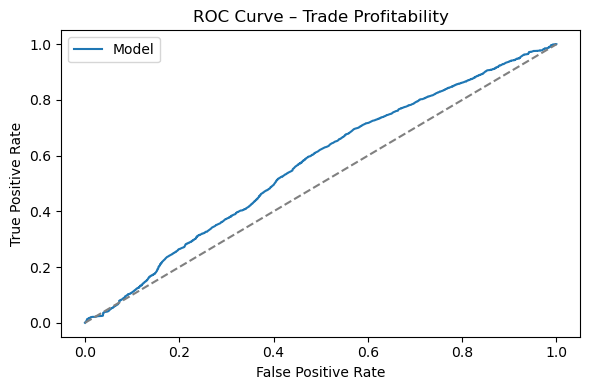

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Model")
plt.plot([0,1], [0,1], "--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Trade Profitability")
plt.legend()
plt.tight_layout()
plt.show()


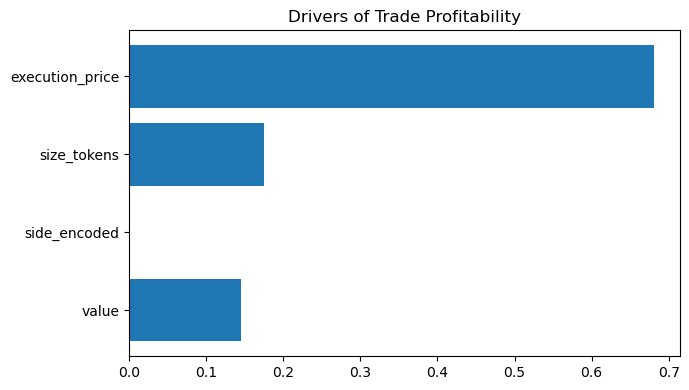

In [31]:
plt.figure(figsize=(7,4))
plt.barh(features, model.feature_importances_)
plt.title("Drivers of Trade Profitability")
plt.tight_layout()
plt.show()


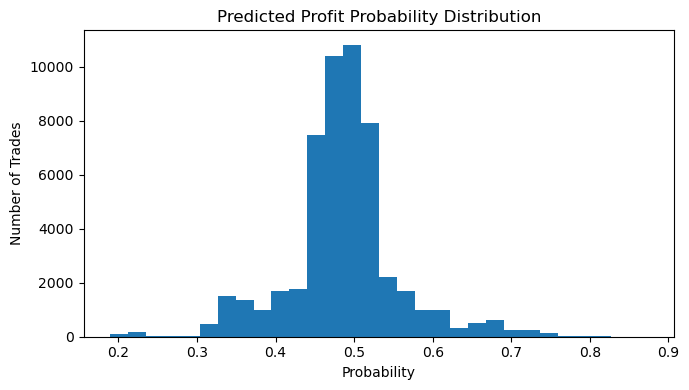

In [32]:
plt.figure(figsize=(7,4))
plt.hist(y_prob, bins=30)
plt.title("Predicted Profit Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()


In [33]:
df_test = X_test.copy()
df_test["prob"] = y_prob
df_test["actual"] = y_test.values


In [34]:
for t in [0.55, 0.6, 0.65, 0.7]:
    subset = df_test[df_test["prob"] > t]
    winrate = subset["actual"].mean()
    print(f"Threshold {t} | Trades {len(subset)} | Winrate {winrate:.3f}")


Threshold 0.55 | Trades 6283 | Winrate 0.372
Threshold 0.6 | Trades 3130 | Winrate 0.329
Threshold 0.65 | Trades 1773 | Winrate 0.262
Threshold 0.7 | Trades 618 | Winrate 0.484
